## Inverse Cooking: Recipe Generation from Food Images

In [22]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args_old import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from PIL import Image, ImageFile
import time
import pandas as pd

Set ```data_dir``` to the path including vocabularies and model checkpoint

In [2]:
data_dir = '../data'

In [3]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [4]:
torch.cuda.is_available()

True

In [5]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
#ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_ingrs.pkl'), 'rb'))
#ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
#vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_toks.pkl'), 'rb')).idx2word
#pickle.dump(ingrs_vocab, open('../demo/ingr_vocab.pkl', 'wb'))
#pickle.dump(vocab, open('../demo/instr_vocab.pkl', 'wb'))

ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [6]:
print (instrs_vocab_size, ingr_vocab_size)

23231 1488


In [7]:
ingr_df = pd.DataFrame(ingrs_vocab)
ingr_df.head()

,0
0,<end>
1,macaroni
2,cheese
3,celery
4,pimentos


In [8]:
# instrs_df = pd.DataFrame(vocab)
# instrs_df.head()
vocab

{0: '<start>',
 1: '<end>',
 2: '<eoi>',
 3: 'cook',
 4: 'macaroni',
 5: 'according',
 6: 'to',
 7: 'package',
 8: 'directions',
 9: ';',
 10: 'drain',
 11: 'well',
 12: '.',
 13: 'cold',
 14: 'combine',
 15: ',',
 16: 'cheese',
 17: 'cubes',
 18: 'celery',
 19: 'green',
 20: 'pepper',
 21: 'and',
 22: 'pimento',
 23: 'blend',
 24: 'together',
 25: 'mayonnaise',
 26: 'or',
 27: 'possibly',
 28: 'salad',
 29: 'dressing',
 30: 'vinegar',
 31: 'salt',
 32: 'dill',
 33: 'weed',
 34: 'add',
 35: 'in',
 36: 'mix',
 37: 'toss',
 38: 'lightly',
 39: 'cover',
 40: 'refrigeratewell',
 41: 'serve',
 42: 'lettuce',
 43: 'lined',
 44: 'bowl',
 45: 'if',
 46: 'you',
 47: 'like',
 48: 'makes',
 49: '6',
 50: 'servings',
 51: 'dilly',
 52: 'recipe',
 53: 'the',
 54: 'tomatoes',
 55: 'a',
 56: 'food',
 57: 'processor',
 58: 'with',
 59: 'pinch',
 60: 'of',
 61: 'puree',
 62: 'until',
 63: 'smooth',
 64: 'onions',
 65: 'bell',
 66: 'peppers',
 67: 'cucumbers',
 68: 'tomato',
 69: 'large',
 70: 'chill',


In [9]:
# resize the image into a square with black padding
from PIL import Image, ImageOps

desired_size = 224
im_pth = "/home/eganlau/dev/paper/inversecooking/data/demo_imgs/3.jpg"

im = Image.open(im_pth)
old_size = im.size  # old_size[0] is in (width, height) format
print(old_size)

ratio = float(desired_size)/max(old_size)
new_size = tuple([int(x*ratio) for x in old_size])
# use thumbnail() or resize() method to resize the input image
print(new_size)


# thumbnail is a in-place operation

# im.thumbnail(new_size, Image.ANTIALIAS)

im = im.resize(new_size, Image.ANTIALIAS)
im_resized = im.resize((desired_size,desired_size))

# create a new image and paste the resized on it

new_im = Image.new("RGB", (desired_size, desired_size))
new_im.paste(im, ((desired_size-new_size[0])//2,
                    (desired_size-new_size[1])//2))

# im_resized.show()
# im.show()
# new_im.show()

(1200, 1600)
(168, 224)


In [10]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = os.path.join(data_dir, 'modelbest.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)


/home/eganlau/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:47: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


loaded model
Elapsed time: 3.608088731765747


In [11]:
args2 = get_parser()
print(args2.embed_size)
from torchvision.models import resnet18, resnet50
globals()['resnet50'](False)

512


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [12]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [13]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

Set ```use_urls = True``` to get recipes for images in ```demo_urls```. 

You can also set ```use_urls = False``` and get recipes for images in the path in ```data_dir/test_imgs```.

In [26]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = False # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = os.path.join(data_dir, 'demo_imgs/fittime')

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
            'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_files = demo_urls if use_urls else demo_imgs

In [27]:
image_folder
ImageFile.LOAD_TRUNCATED_IMAGES = True

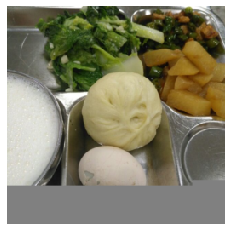

RECIPE 1

Title: Sweet potato and onion soup

Ingredients:
onion, pepper, potato, water, oil, salt, soy_sauce, clove

Instructions:
-Heat oil in a large pot over medium heat.
-Add onion and garlic and cook until soft, about 5 minutes.
-Add sweet potato and cook until tender, about 5 minutes.
-Add water, soy sauce, salt and pepper.
-Bring to a boil, reduce heat to low and simmer until sweet potato is tender, about 20 minutes.
RECIPE 2

Title: Homemade gyoza or potato gyoza skins

Ingredients:
onion, pepper, potato, water, oil, salt, soy_sauce, clove

Instructions:
-Boil the potato skins until soft.
-Mash them with a potato masher and combine with the ingredients.
-Roll into a ball, and flatten into a thickness.
-Cut into 6 equal portions.
-Heat oil in a frying pan and fry each side of the gyoza skins.
-Fry until crispy.
RECIPE 3

Title: Potato soup with green onion (soy sauce)

Ingredients:
onion, pepper, potato, water, oil, salt, soy_sauce, clove

Instructions:
-Heat oil in a saucepan 

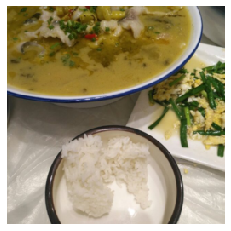

RECIPE 1

Title: Coconut curry soup

Ingredients:
onion, pepper, oil, salt, clove, milk, ginger, cilantro, water, curry

Instructions:
-Heat oil in a large saucepan over medium heat.
-Add onion and garlic and saute until soft, about 5 minutes.
-Add curry powder and ginger and cook for 1 minute.
-Add coconut milk and water and bring to a boil.
-Add salt and pepper to taste.
-Reduce heat and simmer for 10 minutes.
-Add cilantro and serve.
RECIPE 2

Title: Coconut milk soup

Ingredients:
onion, pepper, oil, salt, clove, milk, ginger, cilantro, water, curry

Instructions:
-Heat oil in a large saucepan over medium-high heat; cook and stir onion and minced garlic until onion is soft, about 5 minutes.
-Sprinkle with curry powder, ginger, and cayenne pepper; cook and stir 1 more minute.
-Pour water into onion mixture.
-Bring to a boil, then reduce heat to a simmer; cover, and simmer until onion is very soft, about 20 minutes.
-Puree onion mixture in a blender until smooth; stir into coconut mi

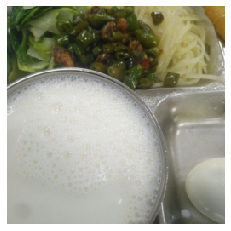

RECIPE 1

Title: Lemon coconut milk

Ingredients:
milk, juice, ice, water

Instructions:
-Put all ingredients in a blender and blend until smooth.
-Pour into a glass and enjoy !
RECIPE 2

Title: Grape juice

Ingredients:
milk, juice, ice, water

Instructions:
-In a blender, blend all ingredients until smooth.
-Serve.
RECIPE 3

Title: Amies green grape smoothie

Ingredients:
milk, juice, ice, water

Instructions:
-Put all ingredients in a blender.
-Blend until smooth.
-Serve and share.
RECIPE 4

Title: Green tea (diabetic friendly)

Ingredients:
milk, juice, ice, water

Instructions:
-Put water and juice concentrate in blender.
-Add milk and blend til smooth.
-Serve over fresh ice in a tall glass.


In [28]:
for img_file in demo_files:
    
    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(256))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
        if valid['is_valid'] or show_anyways:
            
            print ('RECIPE', num_valid)
            num_valid+=1
            #print ("greedy:", greedy[i], "beam:", beam[i])
    
            BOLD = '\033[1m'
            END = '\033[0m'
            print (BOLD + '\nTitle:' + END,outs['title'])

            print (BOLD + '\nIngredients:'+ END)
            print (', '.join(outs['ingrs']))

            print (BOLD + '\nInstructions:'+END)
            print ('-'+'\n-'.join(outs['recipe']))

            print ('='*20)

        else:
            pass
            print ("Not a valid recipe!")
            print ("Reason: ", valid['reason'])
        